# Pharmacology Dissertation Levering Basic Stats To Explain key Drivers of Toxicity


In [25]:
#Data handling
import pandas as pd #This is for the data frame...
import numpy as np

#Charts...
import matplotlib.pyplot as plt #This is for charts...
import seaborn as sns #charts
import matplotlib.cm as cm

from scipy.optimize import curve_fit

from statsmodels.api import OLS

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load in the CSV first, then clean it

In [26]:
data_file_loc = '/Data/EPQ_data.csv'
df = pd.read_csv(data_file_loc, delimiter=',')
df.columns = df.columns.str.lower()
print('loaded epq data csv')

FileNotFoundError: [Errno 2] File /Data/EPQ_data.csv does not exist: '/Data/EPQ_data.csv'

In [3]:
#Show a summary of the data
pd.options.display.float_format = '{:,.5f}'.format
df

,analgesic,dose (mg)\n(b),"ld50 (mg/kg) (oral mouse, * if not)\n( c)",number needed to treat (nnt),equivalent dose to 10mg oral morphine,who pain ladder step,ld50 dose for 40kg human (j)\n(c * 40kg),lamd ld50 for 40kg human/dose\n(b / j),family,sub-family,cox1,cox2,approved/ banned,prescription
0,Acetaminophen,500.00000,338.00000,3.50000,"3,600.00000",1.00000,"13,520.00000",27.04000,Acetaminophen,COX-1 and COX-2,1.00,1.00,Y,N
1,Aspirin,600.00000,"1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",98.67000,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
2,Aspirin 1200,"1,200.00000","1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",49.33000,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
3,Bromfec 10,10.00000,39.00000,2.90000,27.00000,1.00000,"1,560.00000",156.00000,NSAID,COX-2,-,5.00,B,NaN
4,Bromfec 100,100.00000,39.00000,2.60000,27.00000,1.00000,"1,560.00000",15.60000,NSAID,COX-2,-,5.00,B,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Tramadol 150,150.00000,350.00000,2.90000,100.00000,2.00000,"14,000.00000",93.33000,Opioid,Opioid,-,-,Y,Y
58,Tramadol 50,50.00000,350.00000,8.30000,100.00000,2.00000,"14,000.00000",280.00000,Opioid,Opioid,-,-,Y,Y
59,Valdecoxib 20,20.00000,"1,000.00000",1.70000,"1,110.00000",1.00000,"40,000.00000","2,000.00000",NSAID,COX-2,-,4.00,B,NaN
60,Valdecoxib 40,40.00000,"1,000.00000",1.60000,"1,110.00000",1.00000,"40,000.00000","1,000.00000",NSAID,COX-2,-,4.00,B,NaN


In [4]:
#====================================================
#Remove data with zero-ed out key metrics....
#====================================================
#we dont want it in the stat analysis as the zeros will mess up our analysis
df = df[(np.isnan(df['lamd ld50 for 40kg human/dose\n(b / j)']) != True)]


In [5]:
#Get the key metrics
x = df['ld50 (mg/kg) (oral mouse, * if not)\n( c)']
y = df['equivalent dose to 10mg oral morphine']
z = df['lamd ld50 for 40kg human/dose\n(b / j)']

#[c for c in df_dummies_missing.columns if c not in ['name', 'sedol', 'year']]
#Clean function
def clean_data(df: pd.DataFrame):
    df = df.replace(np.nan, 0)
    #df = df.apply(pd.to_numeric, errors='coerce')
    return df

#Remove nans and infs
x = clean_data(x)
y = clean_data(y)
z = clean_data(z)

df_cut_down = pd.DataFrame([y, x]).transpose()

#Get the extended set
df_extended = pd.DataFrame([y, x, z]).transpose()

In [6]:
df_master = df.copy(deep=True)
df_master = clean_data(df_master)

In [7]:
df_master = clean_data(df_master)
df_master

,analgesic,dose (mg)\n(b),"ld50 (mg/kg) (oral mouse, * if not)\n( c)",number needed to treat (nnt),equivalent dose to 10mg oral morphine,who pain ladder step,ld50 dose for 40kg human (j)\n(c * 40kg),lamd ld50 for 40kg human/dose\n(b / j),family,sub-family,cox1,cox2,approved/ banned,prescription
0,Acetaminophen,500.00000,338.00000,3.50000,"3,600.00000",1.00000,"13,520.00000",27.04000,Acetaminophen,COX-1 and COX-2,1.00,1.00,Y,N
1,Aspirin,600.00000,"1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",98.67000,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
2,Aspirin 1200,"1,200.00000","1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",49.33000,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
3,Bromfec 10,10.00000,39.00000,2.90000,27.00000,1.00000,"1,560.00000",156.00000,NSAID,COX-2,-,5.00,B,0
4,Bromfec 100,100.00000,39.00000,2.60000,27.00000,1.00000,"1,560.00000",15.60000,NSAID,COX-2,-,5.00,B,0
5,Bromfec 25,25.00000,39.00000,2.20000,27.00000,1.00000,"1,560.00000",62.40000,NSAID,COX-2,-,5.00,B,0
6,Bromfec 5,5.00000,39.00000,7.10000,27.00000,1.00000,"1,560.00000",312.00000,NSAID,COX-2,-,5.00,B,0
7,Bromfec 50,50.00000,39.00000,2.40000,27.00000,1.00000,"1,560.00000",31.20000,NSAID,COX-2,-,5.00,B,0
8,Buprenorphine,4.00000,260.00000,3.00000,48.00000,3.00000,"10,400.00000","2,600.00000",Opioid,Opioid,-,-,Y,Y
9,Celecoxib 200,200.00000,810.00000,3.50000,"1,100.00000",1.00000,"32,400.00000",162.00000,NSAID,COX-2,-,3.00,Y,Y


Analyse the data. Look at the skews and so on

# Examine the distributions in *key* features and pairwise relationships

<Figure size 800x640 with 0 Axes>

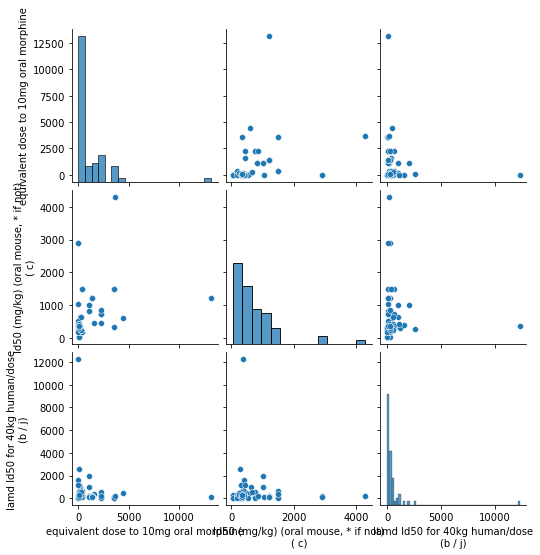

In [8]:
# Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df_extended) #, hue="ld50 dose for human")
#sns.pairplot(df_cut_down, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
#sns.pairplot(df_cut_down, kind="scatter", hue="species", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

# Now examine the relationship bewteen the two critical features: toxicity and efficacy

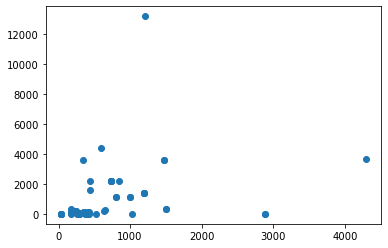

In [9]:
plt.scatter(x,y)

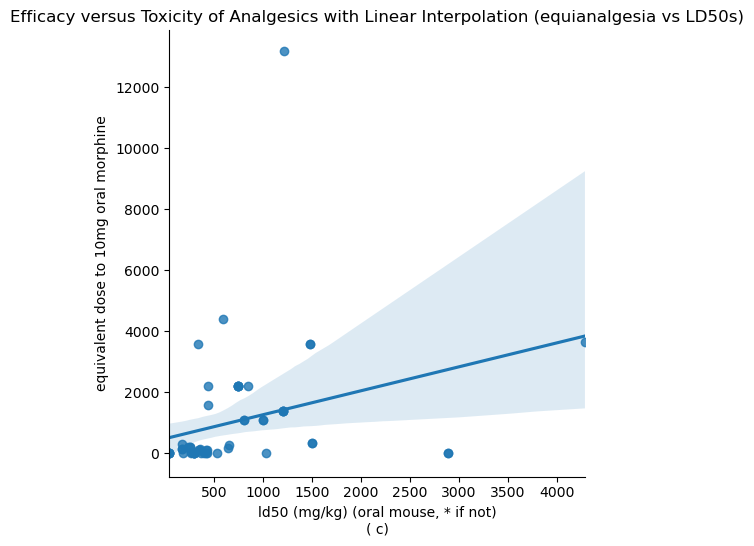

In [10]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='ld50 (mg/kg) (oral mouse, * if not)\n( c)', y='equivalent dose to 10mg oral morphine', data=df)
plt.title("Efficacy versus Toxicity of Analgesics with Linear Interpolation (equianalgesia vs LD50s)");

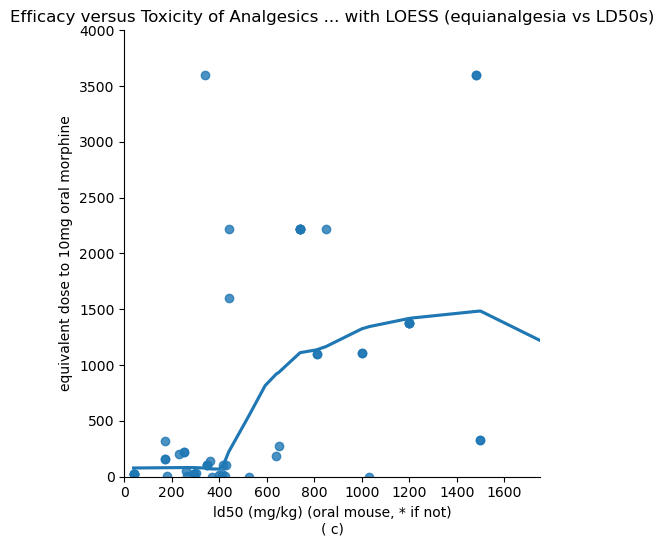

In [11]:
g = sns.lmplot(x='ld50 (mg/kg) (oral mouse, * if not)\n( c)', y='equivalent dose to 10mg oral morphine', data=df, lowess=True)
g.set(xlim=(0,1750),ylim=(0,4000))
plt.title("Efficacy versus Toxicity of Analgesics ... with LOESS (equianalgesia vs LD50s)");
plt.show(g)

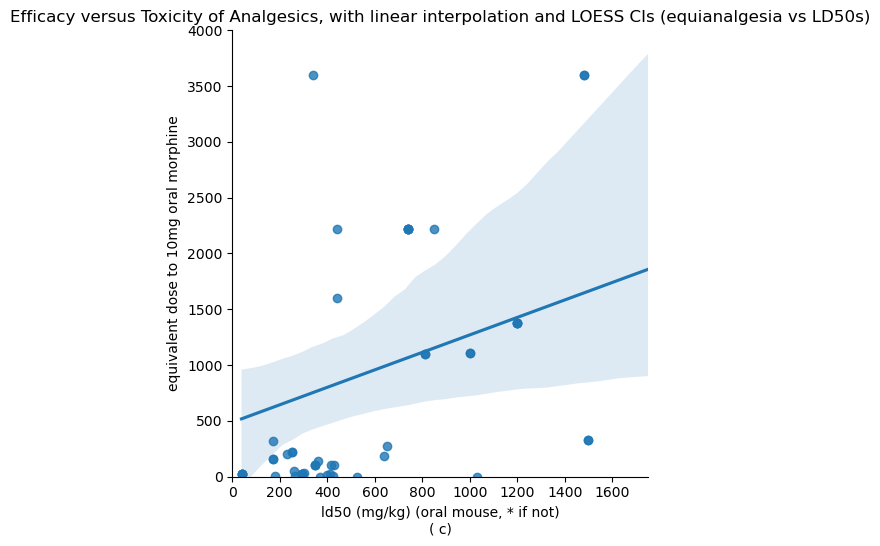

In [12]:
g = sns.lmplot(x='ld50 (mg/kg) (oral mouse, * if not)\n( c)', y='equivalent dose to 10mg oral morphine', data=df, lowess=False)
g.set(xlim=(0,1750),ylim=(0,4000))
plt.title("Efficacy versus Toxicity of Analgesics, with linear interpolation and LOESS CIs (equianalgesia vs LD50s)");
plt.show(g)

In [13]:
#======================================================
#Now get the descriptive stats of this relatiolnship
#======================================================

In [14]:
# Create linear regression object, fit it and dump the resuls
ols_model = OLS(y,x).fit()
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     equivalent dose to 10mg oral morphine   R-squared (uncentered):                   0.264
Model:                                               OLS   Adj. R-squared (uncentered):              0.252
Method:                                    Least Squares   F-statistic:                              21.17
Date:                                   Wed, 20 Oct 2021   Prob (F-statistic):                    2.28e-05
Time:                                           00:03:21   Log-Likelihood:                         -538.30
No. Observations:                                     60   AIC:                                      1079.
Df Residuals:                                         59   BIC:                                      1081.
Df Model:                                              1                                                  
Covariance Type:                               nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ld50 (mg/kg) (oral mouse, * if not)
( c)     1.1101      0.241      4.601      0.000       0.627       1.593
==============================================================================
Omnibus:                       83.040   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1299.295
Skew:                           3.835   Prob(JB):                    7.27e-283
Kurtosis:                      24.468   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Examine the distributions in *ALL* features and pairwise relationships

Expand our eyeballing of the data to the entire dataset. Distributions and relationships. Are they as we expect? If not there could be errors or we could spot something interesting of course....

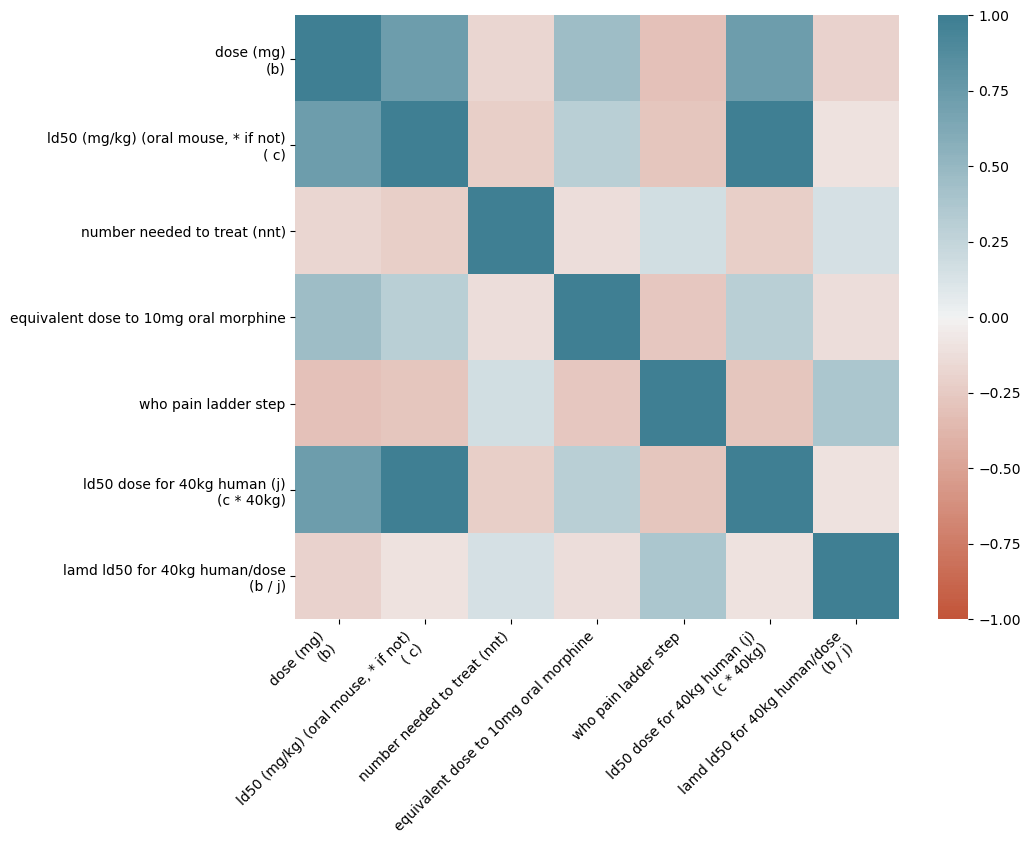

In [15]:
# Examine shape of the data:Correlation matrix to start....
#================================================
corr = df_master.corr(method ='pearson')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

<Figure size 800x640 with 0 Axes>

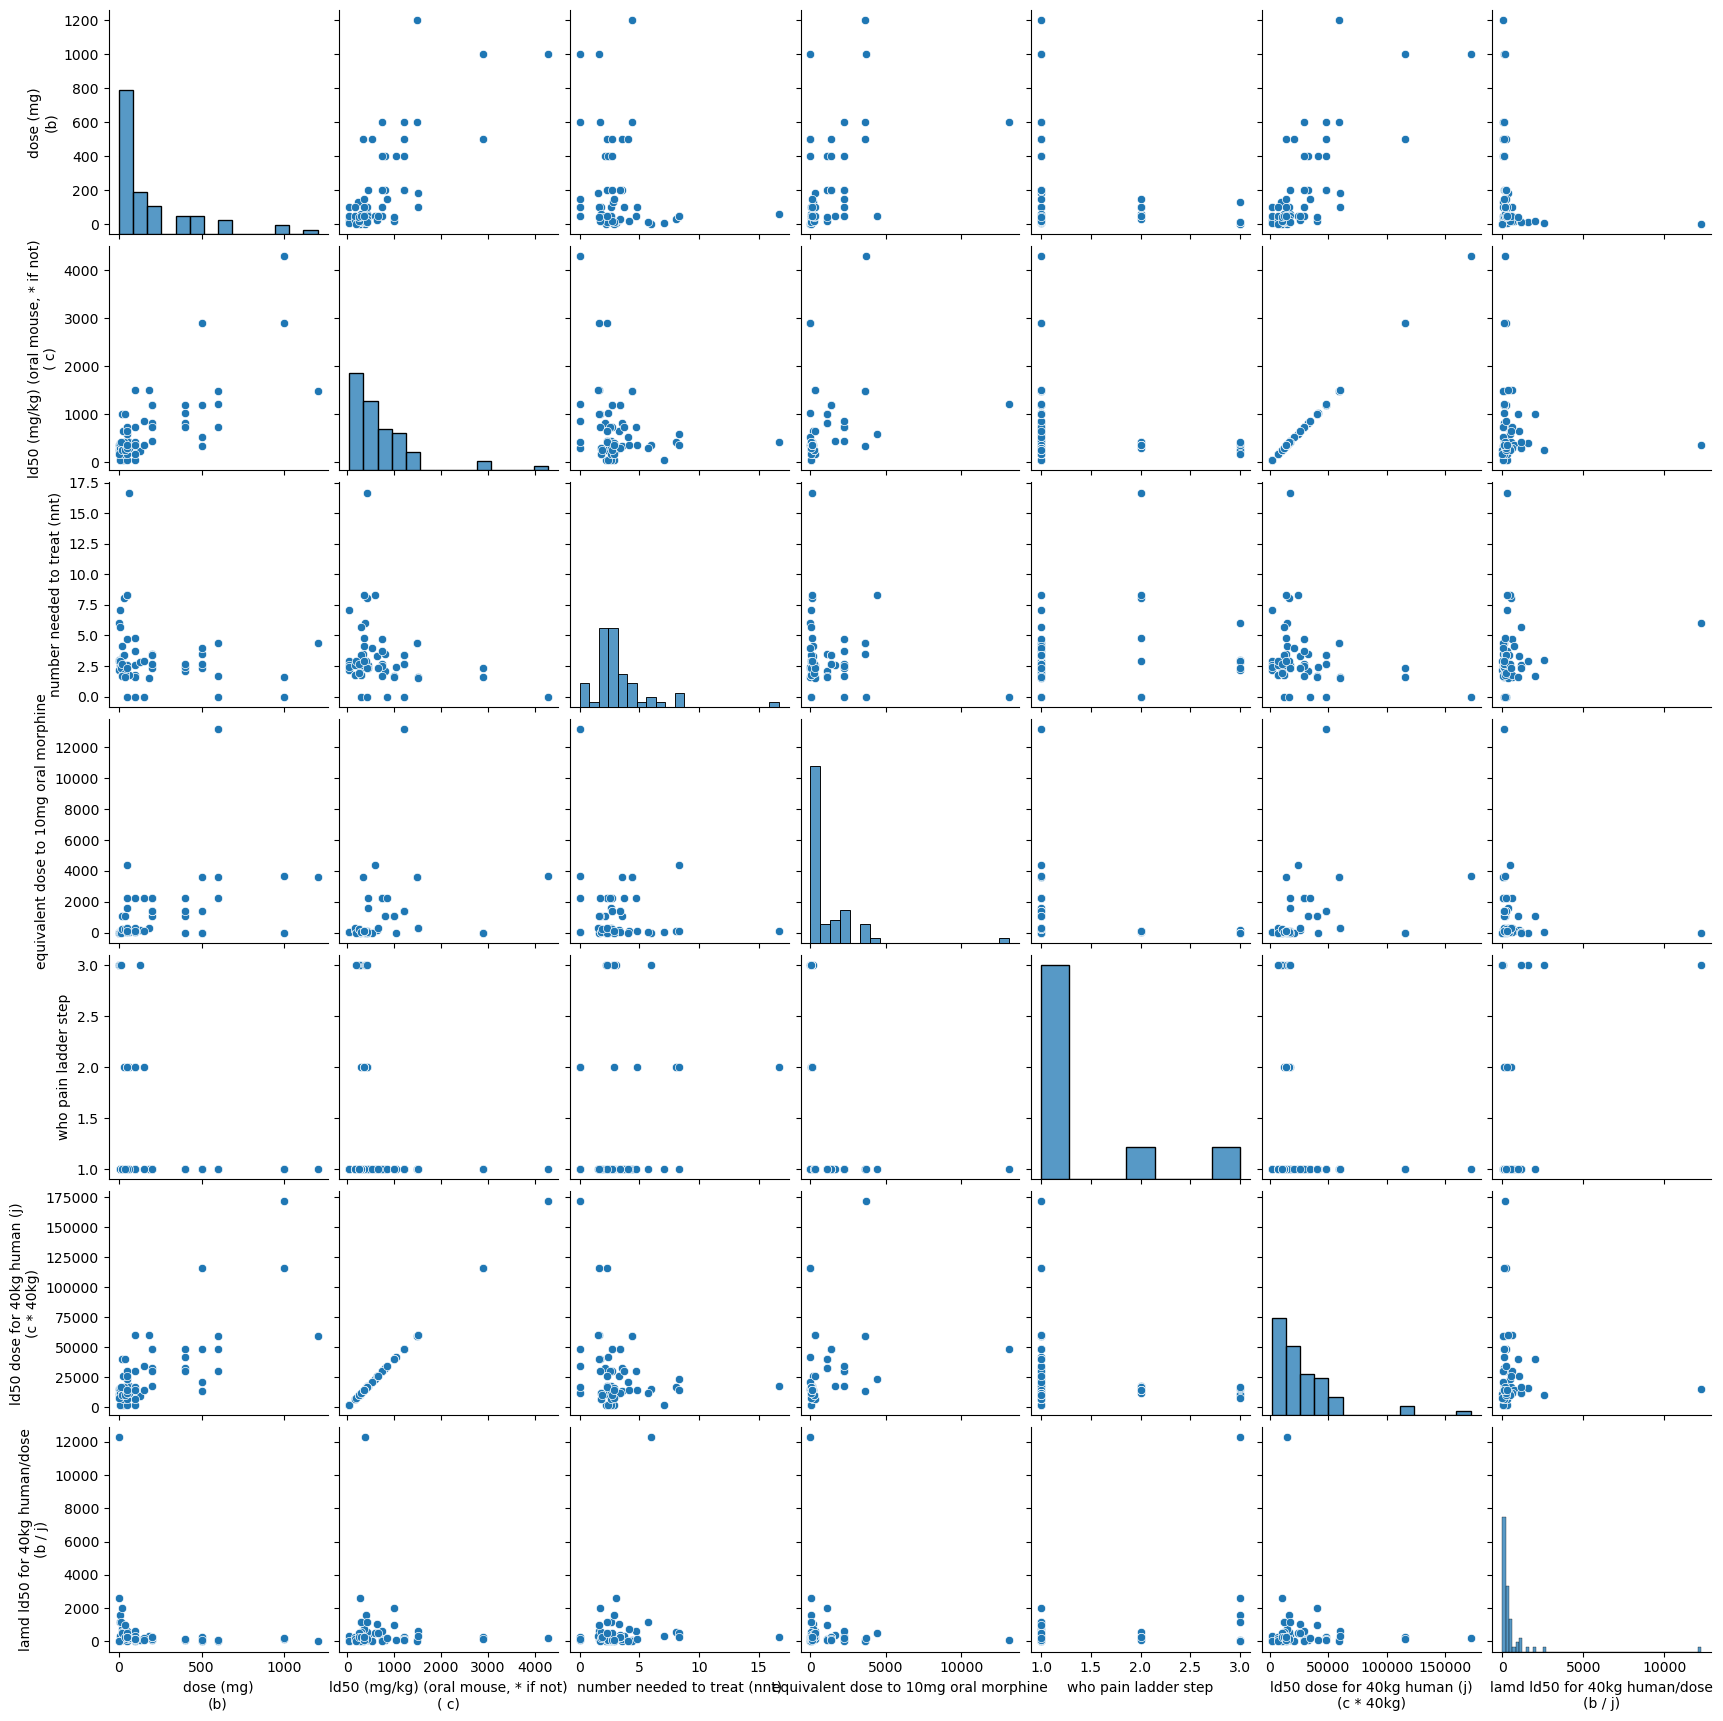

In [16]:
# Deeper look at distributions and pairwise relationships: beware the skew
#========================================================================

#Remove free text columns
col_excl = ['status', 'indication','information', 'm.w.','dmso (mg/ml)max solubility','dmso (mm)max solubility', 'alogp','hbd_count','hba_count','fda nda/anda','approved/ banned', 'information', 'target', 'water (mg/ml)max solubility', 'water (mm)max solubility']
df_master_models = df_master[[x for x in df_master if x not in col_excl]]

#remove columns you dont care about....
col_excl = ['analgesic','family','sub-family'] 
col_excl = np.append(col_excl,['cox1','cox2','approved/ banned','prescription','base dose', 'status', 'indication','information', 'pathway', 'm.w.', 'formula','dmso (mg/ml)max solubility','dmso (mm)max solubility', 'formula', 'form', 'alogp','hbd_count','hba_count','rotatablebond','fda nda/anda','approved/ banned', 'information', 'target', 'water (mg/ml)max solubility', 'water (mm)max solubility','formula', 'form'])
df_master_models = df_master_models[[x for x in df_master_models.columns if x not in col_excl]]

#Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df_master_models) #, hue='ld50 dose for human')
plt.show()

# Split the data by family.... are there better relationships between toxicity and efficacy?

Lets look at the distribution of our toxicity index by steps in the WHO pain ladded. Anything interesting here?

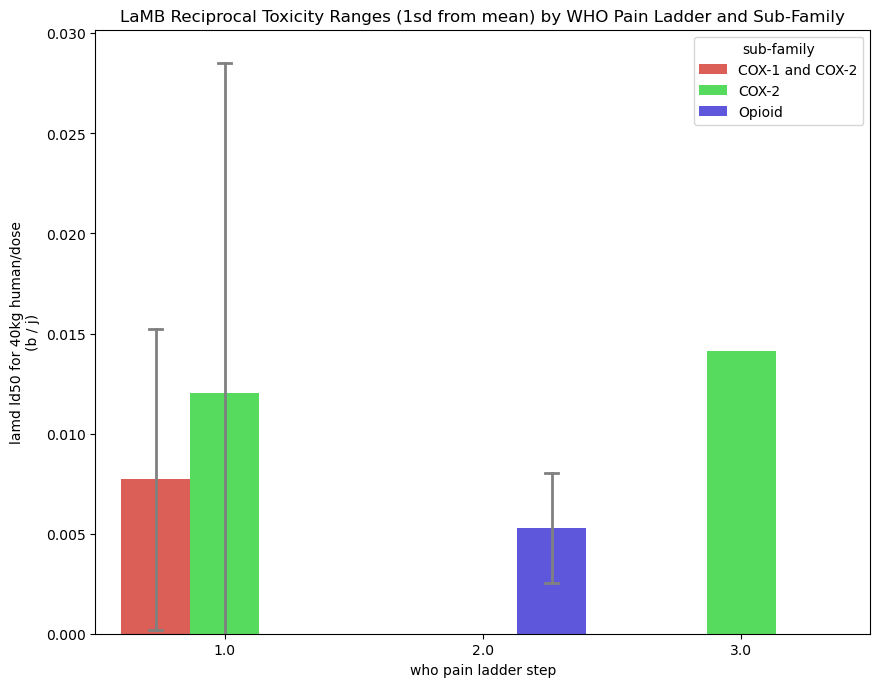

In [17]:
#===================================================
# Box plot RECIPOCAL OF lamd
#===================================================

#Reciprocal of lamd...
df_master['lamd ld50 for 40kg human/dose\n(b / j)'] = 1 / df_master['lamd ld50 for 40kg human/dose\n(b / j)']

vals_family = pd.unique(df_master['who pain ladder step'])
#vals_family = ['cox-1','cox-2','cox-1 and cox-2', 'opioid']
vals_family = vals_family.sort()

# create plot
sns.barplot(x = 'who pain ladder step', y = 'lamd ld50 for 40kg human/dose\n(b / j)', hue = 'sub-family', data = df_master,
            palette = 'hls',
            order = vals_family,  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )


plt.ylim(0,)
plt.title('LaMB Reciprocal Toxicity Ranges (1sd from mean) by WHO Pain Ladder and Sub-Family')
plt.show()


In [18]:
df_master

,analgesic,dose (mg)\n(b),"ld50 (mg/kg) (oral mouse, * if not)\n( c)",number needed to treat (nnt),equivalent dose to 10mg oral morphine,who pain ladder step,ld50 dose for 40kg human (j)\n(c * 40kg),lamd ld50 for 40kg human/dose\n(b / j),family,sub-family,cox1,cox2,approved/ banned,prescription
0,Acetaminophen,500.00000,338.00000,3.50000,"3,600.00000",1.00000,"13,520.00000",0.03698,Acetaminophen,COX-1 and COX-2,1.00,1.00,Y,N
1,Aspirin,600.00000,"1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",0.01013,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
2,Aspirin 1200,"1,200.00000","1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",0.02027,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
3,Bromfec 10,10.00000,39.00000,2.90000,27.00000,1.00000,"1,560.00000",0.00641,NSAID,COX-2,-,5.00,B,0
4,Bromfec 100,100.00000,39.00000,2.60000,27.00000,1.00000,"1,560.00000",0.06410,NSAID,COX-2,-,5.00,B,0
5,Bromfec 25,25.00000,39.00000,2.20000,27.00000,1.00000,"1,560.00000",0.01603,NSAID,COX-2,-,5.00,B,0
6,Bromfec 5,5.00000,39.00000,7.10000,27.00000,1.00000,"1,560.00000",0.00321,NSAID,COX-2,-,5.00,B,0
7,Bromfec 50,50.00000,39.00000,2.40000,27.00000,1.00000,"1,560.00000",0.03205,NSAID,COX-2,-,5.00,B,0
8,Buprenorphine,4.00000,260.00000,3.00000,48.00000,3.00000,"10,400.00000",0.00038,Opioid,Opioid,-,-,Y,Y
9,Celecoxib 200,200.00000,810.00000,3.50000,"1,100.00000",1.00000,"32,400.00000",0.00617,NSAID,COX-2,-,3.00,Y,Y


Lets' now rank everything by our therapeutic index to see the best and worst analgesics. Colours are for family

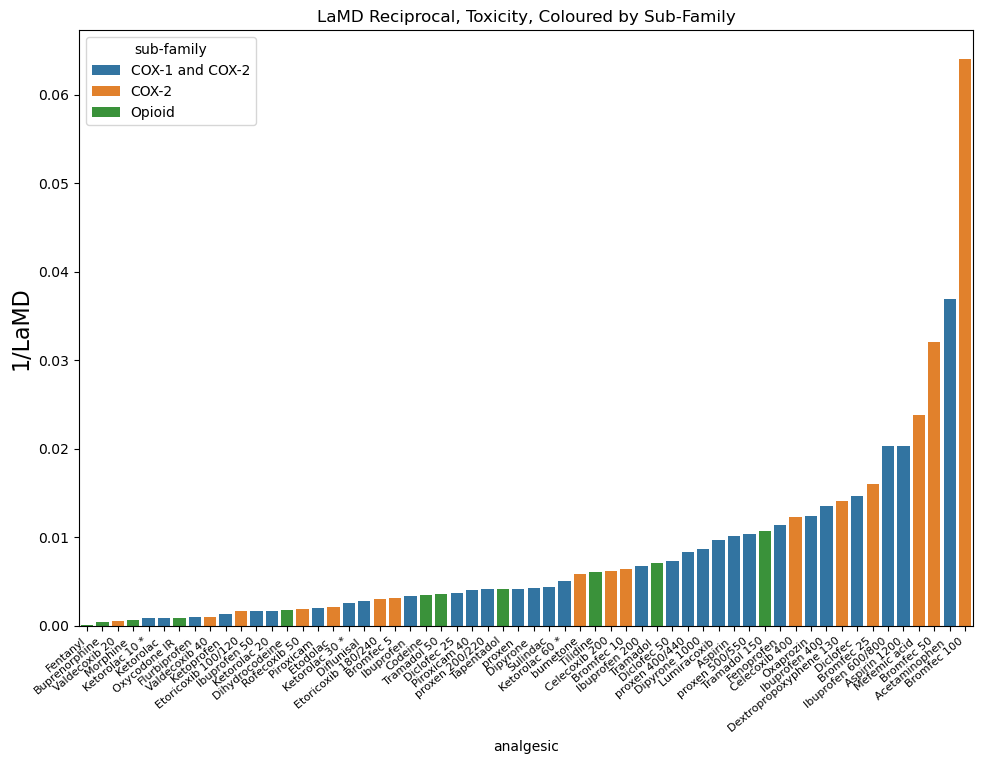

In [19]:
#===================================================
# Sorted bar chart - lamd RECIPROCAL
#===================================================

#remove zeros....
df_master = df_master[(df_master_models['lamd ld50 for 40kg human/dose\n(b / j)'] != 0)]

ax = sns.barplot(x = 'analgesic', y = 'lamd ld50 for 40kg human/dose\n(b / j)', data = df_master, dodge = False,
            order=df_master.sort_values('lamd ld50 for 40kg human/dose\n(b / j)')['analgesic'], hue = 'sub-family')
plt.title('LaMD Reciprocal, Toxicity, Coloured by Sub-Family')
#plt.xticks(rotation=45)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

plt.ylabel('1/LaMD', fontsize=16)
plt.xticks(fontsize=8)
plt.show()

# Regression model to explain the drivers of LaMD


In [20]:
df_master

,analgesic,dose (mg)\n(b),"ld50 (mg/kg) (oral mouse, * if not)\n( c)",number needed to treat (nnt),equivalent dose to 10mg oral morphine,who pain ladder step,ld50 dose for 40kg human (j)\n(c * 40kg),lamd ld50 for 40kg human/dose\n(b / j),family,sub-family,cox1,cox2,approved/ banned,prescription
0,Acetaminophen,500.00000,338.00000,3.50000,"3,600.00000",1.00000,"13,520.00000",0.03698,Acetaminophen,COX-1 and COX-2,1.00,1.00,Y,N
1,Aspirin,600.00000,"1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",0.01013,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
2,Aspirin 1200,"1,200.00000","1,480.00000",4.40000,"3,600.00000",1.00000,"59,200.00000",0.02027,NSAID,COX-1 and COX-2,1.00,1.00,Y,N
3,Bromfec 10,10.00000,39.00000,2.90000,27.00000,1.00000,"1,560.00000",0.00641,NSAID,COX-2,-,5.00,B,0
4,Bromfec 100,100.00000,39.00000,2.60000,27.00000,1.00000,"1,560.00000",0.06410,NSAID,COX-2,-,5.00,B,0
5,Bromfec 25,25.00000,39.00000,2.20000,27.00000,1.00000,"1,560.00000",0.01603,NSAID,COX-2,-,5.00,B,0
6,Bromfec 5,5.00000,39.00000,7.10000,27.00000,1.00000,"1,560.00000",0.00321,NSAID,COX-2,-,5.00,B,0
7,Bromfec 50,50.00000,39.00000,2.40000,27.00000,1.00000,"1,560.00000",0.03205,NSAID,COX-2,-,5.00,B,0
8,Buprenorphine,4.00000,260.00000,3.00000,48.00000,3.00000,"10,400.00000",0.00038,Opioid,Opioid,-,-,Y,Y
9,Celecoxib 200,200.00000,810.00000,3.50000,"1,100.00000",1.00000,"32,400.00000",0.00617,NSAID,COX-2,-,3.00,Y,Y


In [21]:
# Prep data/dummy variables etc...
#=====================================
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression


#Reciprocal of lamd... ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#df_master['lamd ld50 for 40kg human/dose\n(b / j)'] = 1 / df_master['lamd ld50 for 40kg human/dose\n(b / j)']

#dummy variable for categorical variables
#========================================
cols_to_getdummies = ['sub-family','family','prescription','approved/ banned']
df_master_dums = pd.get_dummies(df_master, columns=cols_to_getdummies, prefix=cols_to_getdummies)

#Remove infs
df_master_dums = df_master_dums.replace(np.inf,0)

#Remove the
col_excl = ['analgesic', 'lamd ld50 for 40kg human/dose\n(b / j)'] 
X = df_master_dums[[x for x in df_master_dums.columns if x not in col_excl]]
y = df_master_dums['lamd ld50 for 40kg human/dose\n(b / j)']

X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')
X = X.replace(np.nan, 0)
y = y.replace(np.nan, 0)


In [22]:
#Train and test OLS
#===================
# Create linear regression object, fit it and dump the resuls
ols_model = OLS(y,X).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     lamd ld50 for 40kg human/dose
(b / j)   R-squared:                       0.563
Model:                                               OLS   Adj. R-squared:                  0.407
Method:                                    Least Squares   F-statistic:                     3.609
Date:                                   Wed, 20 Oct 2021   Prob (F-statistic):           0.000514
Time:                                           00:03:29   Log-Likelihood:                 205.73
No. Observations:                                     58   AIC:                            -379.5
Df Residuals:                                         42   BIC:                            -346.5
Df Model:                                             15                                         
Covariance Type:                               nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
dose (mg)
(b)                             3.357e-05   8.13e-06      4.128      0.000    1.72e-05       5e-05
ld50 (mg/kg) (oral mouse, * if not)
( c) -6.608e-09   1.61e-09     -4.098      0.000   -9.86e-09   -3.35e-09
number needed to treat (nnt)                -0.0004      0.001     -0.774      0.443      -0.001       0.001
equivalent dose to 10mg oral morphine     -2.44e-07   6.76e-07     -0.361      0.720   -1.61e-06    1.12e-06
who pain ladder step                        -0.0035      0.005     -0.657      0.514      -0.014       0.007
ld50 dose for 40kg human (j)
(c * 40kg)  -2.643e-07   6.45e-08     -4.098      0.000   -3.94e-07   -1.34e-07
cox1                                        -0.0011      0.002     -0.598      0.553      -0.005       0.003
cox2                                         0.0003      0.001      0.194      0.847      -0.003       0.003
sub-family_COX-1 and COX-2                   0.0054      0.005      1.022      0.313      -0.005       0.016
sub-family_COX-2                             0.0097      0.005      1.882      0.067      -0.001       0.020
sub-family_Opioid                            0.0014      0.007      0.215      0.831      -0.012       0.015
family_Acetaminophen                         0.0180      0.008      2.171      0.036       0.001       0.035
family_NSAID                                -0.0048      0.005     -0.925      0.360      -0.015       0.006
family_Opioid                                0.0033      0.012      0.277      0.783      -0.021       0.027
prescription_0                               0.0085      0.003      2.451      0.018       0.002       0.016
prescription_N                               0.0017      0.006      0.277      0.783      -0.011       0.014
prescription_Y                               0.0062      0.004      1.745      0.088      -0.001       0.013
approved/ banned_B                           0.0088      0.005      1.857      0.070      -0.001       0.018
approved/ banned_N                           0.0024      0.004      0.594      0.555      -0.006       0.011
approved/ banned_Y                           0.0053      0.004      1.385      0.173      -0.002       0.013
==============================================================================
Omnibus:                       77.827   Durbin-Watson:                   2.455
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1160.362
Skew:                           3.574   Prob(JB):                    1.07e-252
Kurtosis:                      23.714   Cond. No.  